In [191]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import random
import fista
import timeit
from itertools import combinations
from scipy.stats import gaussian_kde
from matplotlib.colors import LogNorm

float_formatter = lambda x: "%.3f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})

# 1. Preliminaries

## Load basis functions

In [5]:
'''Load a dictionary of 300 basis functions, each with
dimensions of 16 x 16 pixels.  (~1.2 times overcomplete)'''

bases = np.load('basis1.npz')['basis']
pixels = 16

## Display 100 basis functions

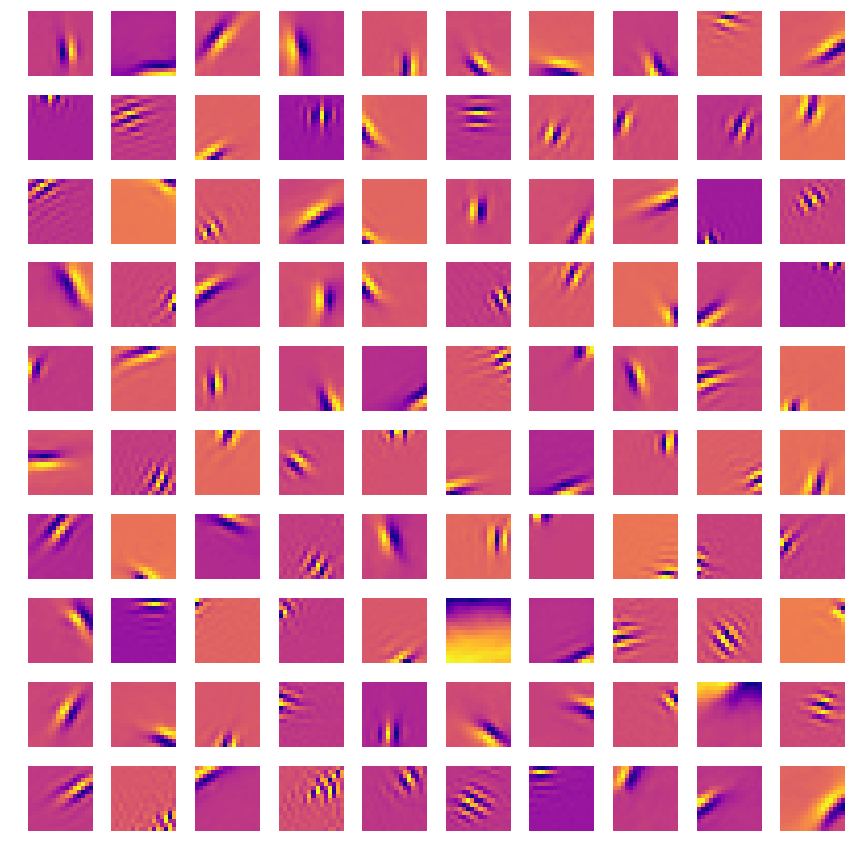

In [6]:
fig, axes = plt.subplots(nrows=10, ncols=10, sharex=True, sharey=True, figsize = (12,12), facecolor = 'white')
axes = axes.ravel()

for i in range(100):      
    axes[i].imshow(np.reshape(bases[:,i], (pixels, pixels)), cmap = 'plasma')
    axes[i].axis('off')
    
plt.tight_layout(h_pad = 1, w_pad = 1)
plt.show()

## Load natural images

In [9]:
IMAGES = scipy.io.loadmat('IMAGES.mat')
IMAGES = IMAGES['IMAGES']
(imsize, imsize, num_images) = np.shape(IMAGES)

## Randomly select image patches

In [10]:
def sample_images(sample_size, IMAGES):
    border = 4  #buffer around the edge of an entire image
    imi = np.ceil(num_images * random.uniform(0, 1))  #pick a random image
    I = np.zeros((pixels**2,sample_size))

    for i in range(sample_size):
        r = border + np.ceil((imsize-pixels-2*border) * random.uniform(0, 1))
        c = border + np.ceil((imsize-pixels-2*border) * random.uniform(0, 1))
        image = IMAGES[int(r):int(r+pixels), int(c):int(c+pixels), int(imi-1)]
        I[:,i] = np.reshape(image, pixels**2) 
        
    return I

In [11]:
I = sample_images(1000, IMAGES)

## Find coefficients of sparse representation

In [12]:
ahat = fista.fista(I, bases, lambdav = 0.1, max_iterations=50)

In [89]:
ahat_list = np.zeros([100, ahat.shape[0], ahat.shape[1]])

## Compute correlations between neuron pairs; plot as histogram

In [38]:
corr_list = []
neuron_pairs = combinations(range(300),2)

for i,j in neuron_pairs:
    corr = np.corrcoef(ahat[i,:], ahat[j,:])[0, 1]
    corr_list.append(corr)
    if abs(corr) > 0.4 and i != j:
        print(i,j)

58 148


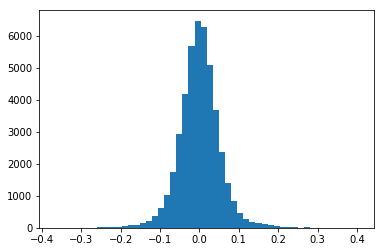

In [24]:
corr_hist = plt.hist(corr_list,50)
plt.show()

0.40471072202


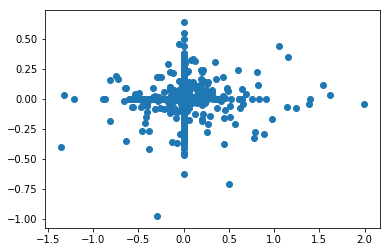

In [57]:
plt.scatter(ahat[56,:], ahat[148,:])
print(np.corrcoef(ahat[58,:], ahat[148,:])[0, 1])
plt.show()

In [180]:
def find_strong_image(neuron1, neuron2):
    for i in range(len(ahat[90,:])):
        if abs(ahat[neuron1,:][i]) > 0.1 and abs(ahat[neuron2,:][i]) > 0.1:
            return(i)
        
def find_strong_images(neuron1, neuron2, cutoff = 0.05):
    image_nums = []
    for i in range(len(ahat[90,:])):
        if abs(ahat[neuron1,:][i]) > cutoff and abs(ahat[neuron2,:][i]) > cutoff:
            image_nums.append(i)
    if len(image_nums) == 0:
        image_nums = find_strong_images(neuron1,neuron2, cutoff = cutoff - 0.05)
    return(image_nums)

In [172]:
print(find_strong_images(58,148))

[191, 669]


In [72]:
def add_noise(image, sigma = 1e-2):
    noise = np.random.normal(0.0, sigma, image.shape)
    return image + noise

def plot_neurons(i,j, responses):
    neuron1 = responses[i,:]
    neuron2 = responses[j,:]
    print(np.corrcoef(neuron1,neuron2)[0, 1])
    plt.scatter(neuron1, neuron2)
    plt.show()

In [175]:
def get_noisy_responses(image):
    for i in range(100):
        ahat_list[i] = fista.fista(add_noise(image, 1e-2), bases, lambdav = 0.1, max_iterations = 50)
    """responses = np.zeros((bases.shape[1], num_trials))
    image_num = find_strong_image(neuron1, neuron2)  
    selected_image = np.reshape(I[:,image_num], (256,1))

    for i in range(num_trials):
        ahat2 = fista.fista(add_noise(selected_image, 1e-2), bases, lambdav = 0.1, max_iterations = 50)
        responses[:, i] = ahat2[:, 0]
        
    corr = np.corrcoef(responses[neuron1,:], responses[neuron2,:])[0, 1]
    
    return(corr)"""
    
def get_noise_correlations(neuron1, neuron2):
    corr = 0
    image_nums = find_strong_images(neuron1, neuron2)
    for image_num in image_nums:
        corr += np.corrcoef(ahat_list[:,neuron1,image_num], ahat_list[:,neuron2,image_num])[0, 1]
    return(corr/len(image_nums))
    

In [92]:
get_noisy_responses(I)

In [181]:
noise_corr_list = []

for neuron1, neuron2 in combinations(range(300),2):
    corr = get_noise_correlations(neuron1, neuron2)
    noise_corr_list.append(corr)

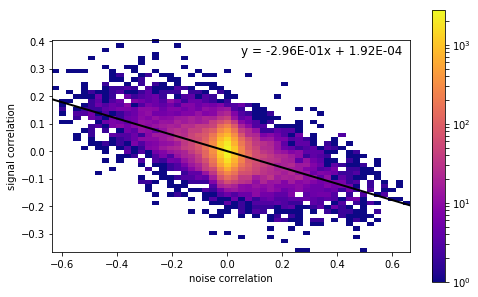

"plt.scatter(noise_corr_list, corr_list)\nplt.axis('equal')\nplt.show()"

In [243]:
fig, ax = plt.subplots(figsize = (8,5))
h = ax.hist2d(noise_corr_list, corr_list,(50,50), cmap = 'plasma', norm = LogNorm())
m,b = np.polyfit(noise_corr_list, corr_list, 1)
ax.plot([-1.0, 1.0], [-m + b, m + b], color='k', linestyle='-', linewidth=2)
s = 'y = {0:1.2E}x + {1:1.2E}'.format(m,b)
ax.text(0.05, 0.35, s, fontsize=12)
plt.xlabel('noise correlation')
plt.ylabel('signal correlation')
ax.set_aspect('equal')
plt.colorbar(h[3])

plt.savefig('foo.png', bbox_inches='tight')
plt.show()

"""plt.scatter(noise_corr_list, corr_list)
plt.axis('equal')
plt.show()"""

In [194]:
def fancy_scatter(x,y):    
    # Calculate the point density
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    fig, ax = plt.subplots()
    ax.scatter(x, y, c=z, s=50, edgecolor='')
    plt.show()

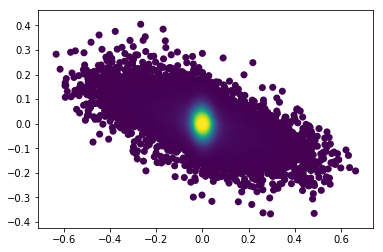

In [202]:
x = np.array(noise_corr_list)
y = np.array(corr_list)
fancy_scatter(x,y)

[-0.111 -0.132 -0.157 -0.112 -0.127 -0.139 -0.158 -0.179 -0.111 -0.150
 -0.164 -0.145 -0.155 -0.171 -0.147 -0.149 -0.149 -0.155 -0.159 -0.151
 -0.154 -0.141 -0.133 -0.127 -0.166 -0.147 -0.168 -0.152 -0.138 -0.127
 -0.166 -0.154 -0.153 -0.134 -0.139 -0.113 -0.120 -0.129 -0.156 -0.160
 -0.156 -0.168 -0.137 -0.148 -0.149 -0.153 -0.164 -0.148 -0.145 -0.153
 -0.156 -0.147 -0.129 -0.172 -0.145 -0.141 -0.138 -0.129 -0.124 -0.139
 -0.133 -0.179 -0.130 -0.134 -0.131 -0.110 -0.161 -0.133 -0.160 -0.146
 -0.140 -0.146 -0.128 -0.152 -0.103 -0.164 -0.143 -0.132 -0.129 -0.139
 -0.111 -0.140 -0.132 -0.121 -0.159 -0.149 -0.140 -0.134 -0.124 -0.114
 -0.130 -0.156 -0.175 -0.125 -0.150 -0.126 -0.126 -0.126 -0.158 -0.149]


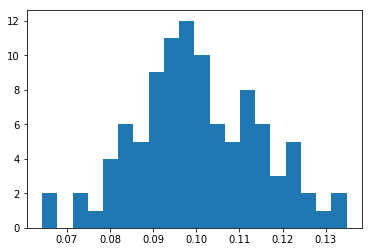

In [119]:
print(ahat_list[:,0,3])
plt.hist(ahat_list[:,0,8], 20)
plt.show()

-0.295571891613


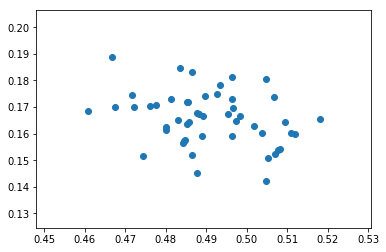

In [74]:
plot_neurons(58,148, responses)

# Signal correlation vs noise correlation

In [84]:
noise_corr_list = []

for neuron1, neuron2 in combinations(range(300),2):
    noise_corr_list.append(get_noise_correlation(neuron1, neuron2))
    

KeyboardInterrupt: 

In [ ]:
corr_hist = plt.hist(noise_corr_list,50)
plt.show()

## Extras

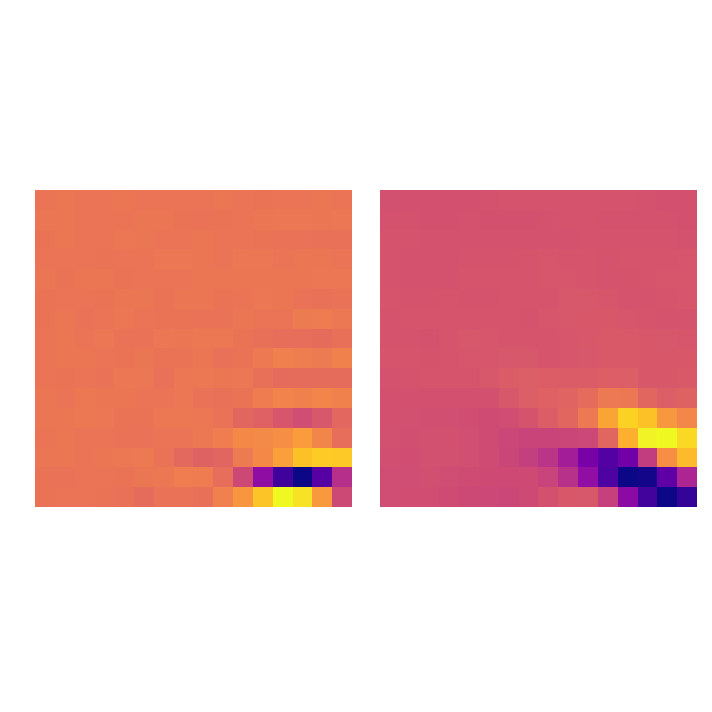

In [50]:
num_images = 15
pixels = 16

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize = (10,10), facecolor = 'white')

axes = axes.ravel()
j = 0
for i in [67,81]:      
    axes[j].imshow(np.reshape(bases[:,i], (pixels, pixels)), cmap = 'plasma')
    axes[j].axis('off')
    j += 1
    
plt.tight_layout(h_pad = 1, w_pad = 1)
plt.show()

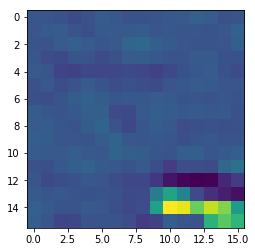

In [51]:
plt.imshow(np.reshape(I[:,835], (pixels, pixels)))
#plt.imshow(np.reshape(add_noise(I[:,1894], 0.1), (pixels,pixels)))
plt.show()

256


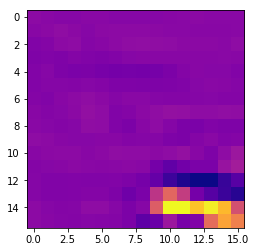

In [52]:
reco = np.dot(bases, responses[:, 1])
plt.imshow(np.reshape(reco, (pixels,pixels)), cmap = 'plasma')
print(reco.size)
plt.show()

In [53]:
print(ahat.shape)

(300, 1000)


67
81
159
190
203
264


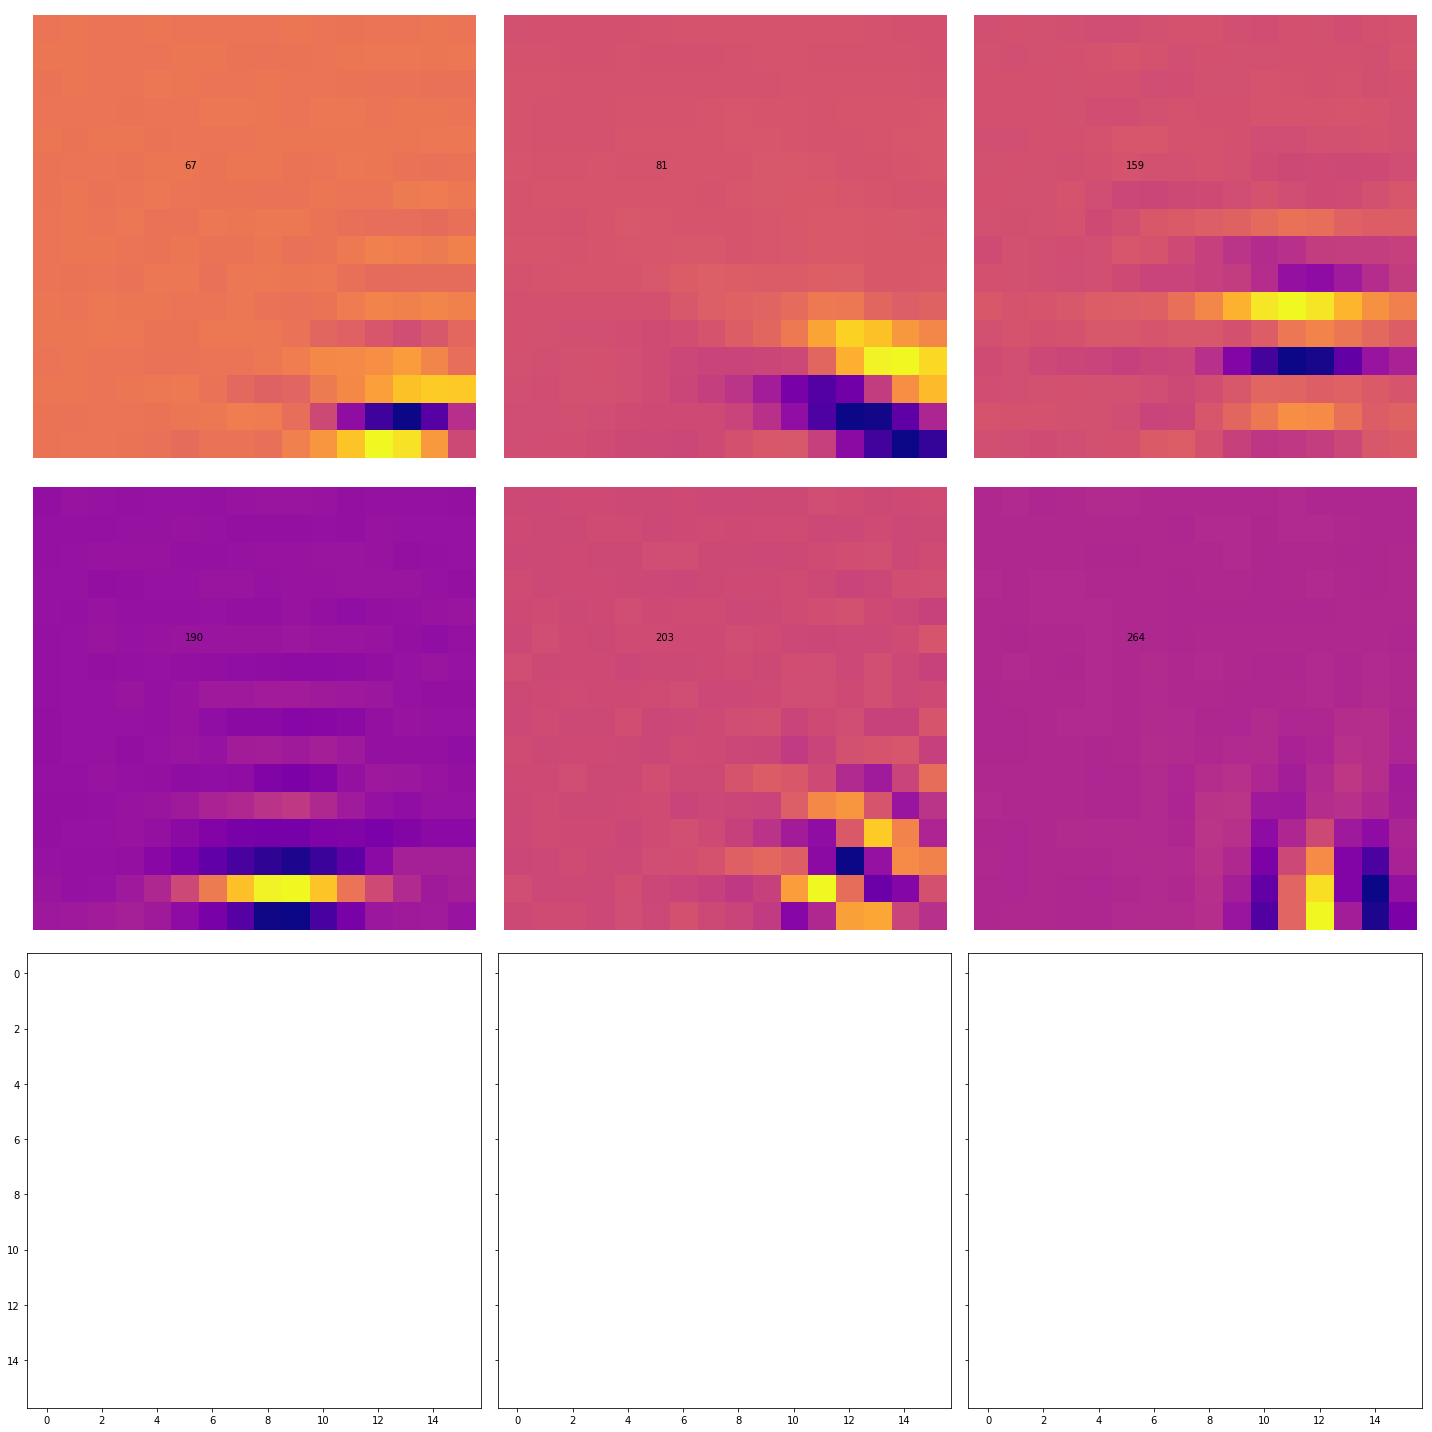

In [59]:
fig, axes = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True, figsize = (20,20), facecolor = 'white')
j = 0
partial_reco = np.zeros(256)
axes = axes.ravel()
for i in range(len(ahat)):  
    if abs(ahat[i,835]) > 0.3:
        print(i)
        #partial_reco += ahat[i]*bases[:,i]
        axes[j].imshow(np.reshape(bases[:,i], (pixels, pixels)), cmap = 'plasma')
        axes[j].text(5,5,str(i))
        axes[j].axis('off')
        j += 1
    
plt.tight_layout(h_pad = 1, w_pad = 1)
plt.show()

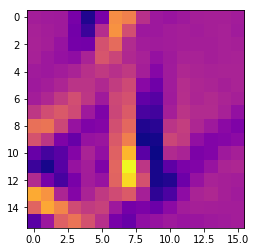

In [74]:
plt.imshow(np.reshape(partial_reco, (pixels, pixels)), cmap = 'plasma')
plt.show()

In [47]:
sums = []
thresh = np.arange(0,1,0.005)
for i in thresh:
    sums.append(np.sum(np.abs(ahat)>i))

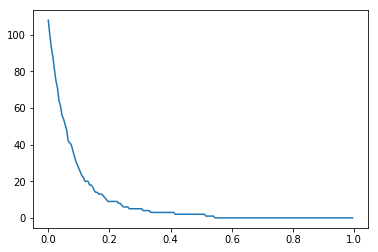

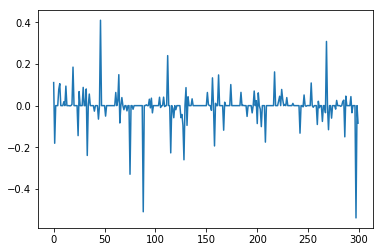

In [33]:
plt.plot(thresh, sums)
plt.show()
plt.plot(ahat)
plt.show()